In [3]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


import pandas as pd
import torch

from utils import NAd_tensor
from config import *

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3.5,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Process Data

In [13]:
data = pd.read_csv(f"{DATA}/chimera.csv")
data.head()

name                                        aligned_seq  \
0    SpyCas9  TGGFSK-ESIL-------------PK-R-N-----S--D-----KL...   
1  Seq1Cas9#  NGGLFD-NNIL----------AKPEK-D-D-----K--K-----KL...   
2   Smu3Cas9  TGGFSK-ESIL-------------PK-G-D-----S--D-----KL...   
3    EfaCas9  KGGFSK-ETVE-------------PK-K-D-----S--S-----KL...   
4   LrhCas9#  --DLFK-QTIYAA-------KDSKER-G-G-----S--K-----QL...   

                                                 seq   mcherry  mcherry_std  \
0  TGGFSKESILPKRNSDKLIARKKDWDPKKYGGFDSPTVAYSVLVVA...  1.000000     0.000000   
1  NGGLFDNNILAKPEKDDKKKLFPIKNSLSTTSYGGYARATIAYSIL... -0.000288     0.012243   
2  TGGFSKESILPKGDSDKLIPRKTKKFYWDTKKYGGFDSPIVAYSIL...  1.234746     0.015800   
3  KGGFSKETVEPKKDSSKLLPRKNNWDPAKYGGLGSPNVAYTVAFTY...  1.177531     0.020198   
4  DLFKQTIYAAKDSKERGGSKQLIPKKQGYPTQVYGGYTRENTAYLA... -0.041357     0.012211   

   mcherry_own_pam  mcherry_std_own_pam  identity      pam  type  expected  \
0         1.000000             0.000000     1.000      NGG  II-A         1   
1         1.007680             0.008109     0.590     NAGA  II-A         0   
2         0.970930             0.001128     0.648    NGGDT  II-A         1   
3         1.015400             0.000415     0.530  BGGDTNN  II-A         1   
4        -0.001896             0.023610     0.279   NNTAAW  II-A         0   

   Unnamed: 11  
0            0  
1            1  
2            2  
3            3  
4            4

In [14]:
data.iloc[0] = "SpyCas9 (WT)"

In [3]:
seq_cas9 = data.aligned_seq[0]
N = len(data.seq[0])
idx = [i for i, x in enumerate(seq_cas9) if x != "-"]
ids = []
for x in data.aligned_seq:
    sim = 0
    for i, (x_, x_cas9) in enumerate(zip(x, seq_cas9)):
        if i not in idx:
            continue
        if x_ == x_cas9:
            sim+=1
    ids.append(sim/N)
data.identity = ids

In [4]:
def from_df_to_fasta(folder, df, prefix=""):
    records_aligned = []
    records_unaligned = []
    for i, data in enumerate(df.itertuples()):
        records_aligned.append(SeqRecord(Seq(data.aligned_seq), id=(f"{str(data.name)}|{str(data.mcherry)}|{str(data.mcherry_std)}|{str(data.identity)}|{str(data.pam)}|{str(data.expected)}")))
        records_unaligned.append(SeqRecord(Seq(data.seq), id=(f"{str(data.name)}|{str(data.mcherry)}|{str(data.mcherry_std)}|{str(data.identity)}|{str(data.pam)}|{str(data.expected)}")))
    with open(f"{folder}/chimera_aligned.fasta", "w") as handle:
        SeqIO.write(records_aligned, handle, "fasta")
    with open(f"{folder}/chimera_unaligned.fasta", "w") as handle:
        SeqIO.write(records_unaligned, handle, "fasta")

In [5]:
from_df_to_fasta(DATA, data)

## Build Tree

In [4]:
align = AlignIO.read(f'{DATA}/chimera_aligned.fasta','fasta')
for i, a in enumerate(align):
    aa = a.name.split("|")
    align[i].id = f"{aa[0]}\t(PAM: {aa[4]})\tId: {int(float(aa[3])*100)}%"
print(align)

Alignment with 11 rows and 736 columns
TGGFSK-ESIL-------------PK-R-N-----S--D-----...YET SpyCas9	(PAM: NGG)	Id: 100%
NGGLFD-NNIL----------AKPEK-D-D-----K--K-----...YET Seq1Cas9#	(PAM: NAGA)	Id: 26%
TGGFSK-ESIL-------------PK-G-D-----S--D-----...YET Smu3Cas9	(PAM: NGGDT)	Id: 57%
KGGFSK-ETVE-------------PK-K-D-----S--S-----...YET EfaCas9	(PAM: BGGDTNN)	Id: 44%
--DLFK-QTIYAA-------KDSKER-G-G-----S--K-----...L-- LrhCas9#	(PAM: NNTAAW)	Id: 19%
KGQLFN-LTIK----------DKTQL-K-K-----N--V-----...FV- TbaCas9#	(PAM: NNNATTT)	Id: 21%
TGGFSK-ESIL-------------SK-R-E-----S--A-----...YET ScCas9	(PAM: NNG)	Id: 52%
NGGLFD-DNPK-----------SPLE-V-T-----P--S-----...YET SmacCas9#	(PAM: NAAN)	Id: 34%
-GGFSD-EMLV-------------PK-S-D-----S--G-----...YET LanCas9	(PAM: NRG)	Id: 37%
KGELFN-ATIA----------GKKDY-K-K-----G--K-----...YEK FmaCas9#	(PAM: NNGAC)	Id: 14%
KGEFSK-ATIK-------------PK-G-N-----S--S-----...YE- LmoCas9	(PAM: NGG)	Id: 44%


In [5]:
calculator = DistanceCalculator('blosum62')
distMatrix = calculator.get_distance(align)

constructor = DistanceTreeConstructor()# Construct the phlyogenetic tree using UPGMA algorithm
UGMATree = constructor.upgma(distMatrix)# Construct the phlyogenetic tree using NJ algorithm
NJTree = constructor.nj(distMatrix)

for x in UGMATree.find_clades():
    if "Inner" in x.name:
        x.name = ""

In [6]:
import pylab

/home/malbranke/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:90: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/malbranke/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:203: RuntimeWarning: Glyph 9 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)
/home/malbranke/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/malbranke/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


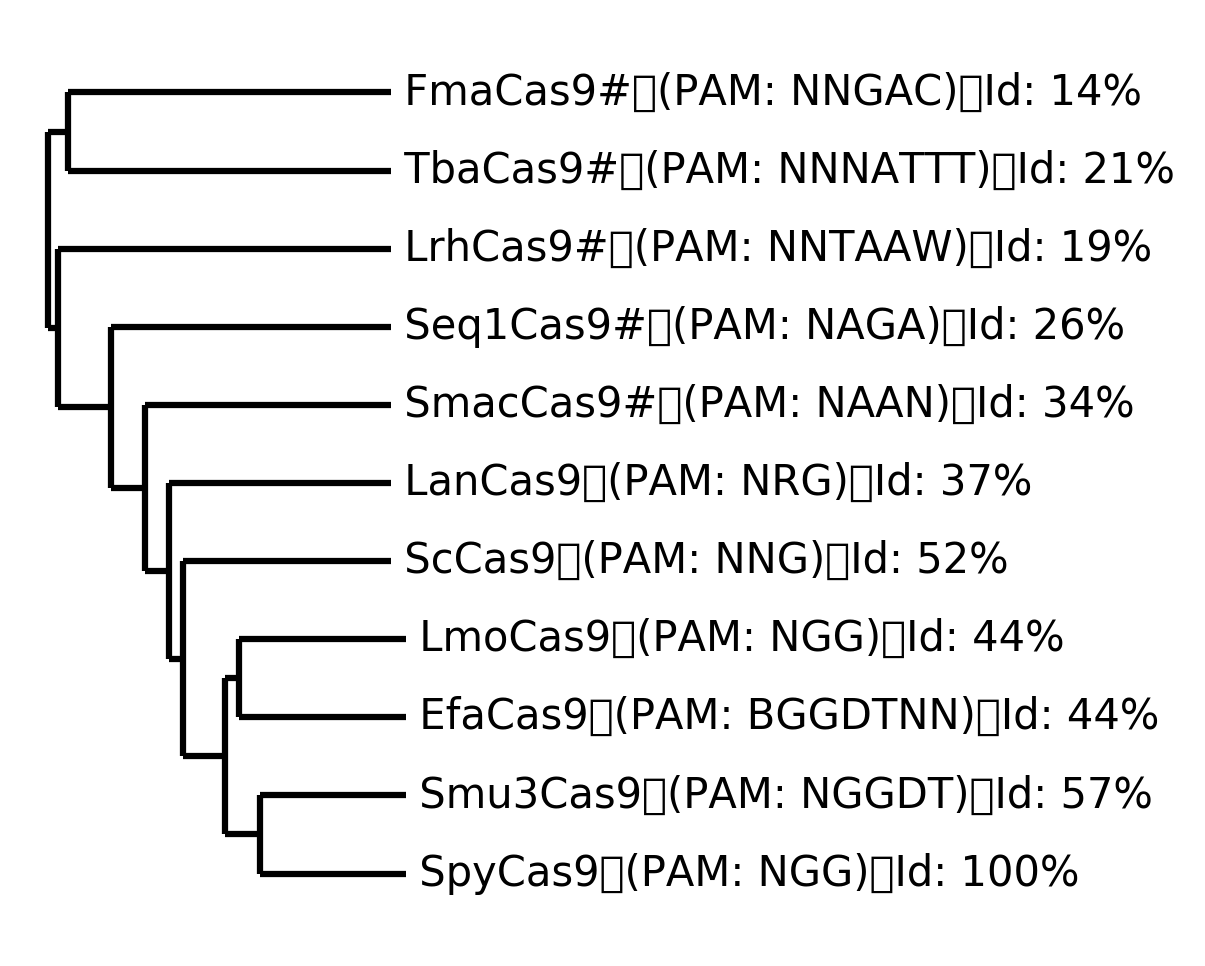

In [7]:
plt.rcParams["figure.figsize"] = (2,4)

Phylo.draw(UGMATree,axis=["off"],do_show=False)
fig = plt.gcf()
fig.savefig(f"{DATA}/tree.svg", format="svg")

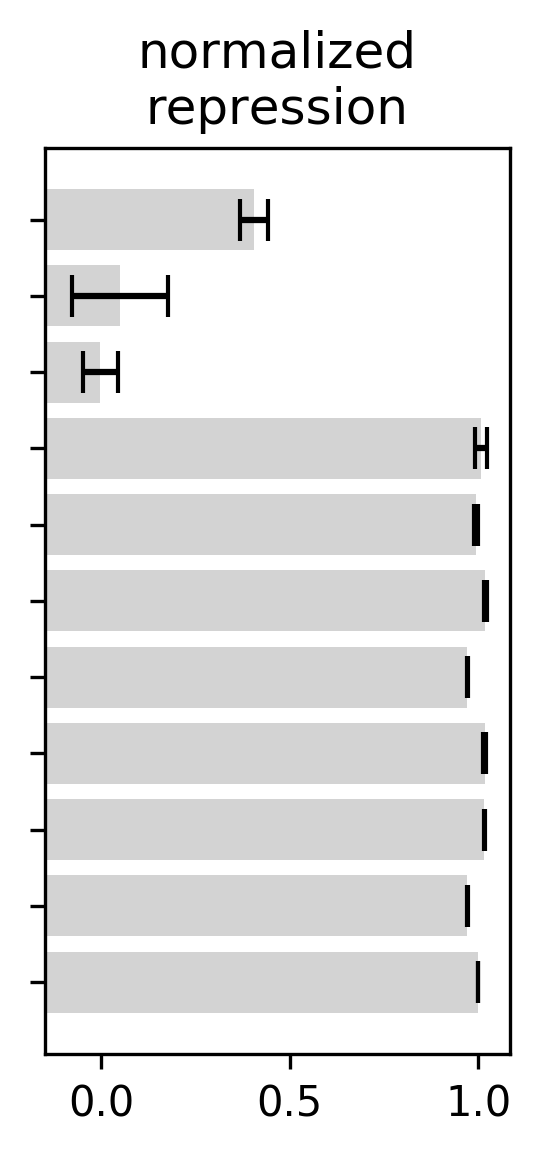

In [11]:
plt.figure()
order = [9,5,4,1,7,8,6,10,3,2,0][::-1]

plt.barh(range(11), data.mcherry_own_pam.values[order]+0.15, color = "lightgray", #["red" if x<0.5 else "green" for x in data.mcherry_own_pam.values[order]],
        left = -0.15,  xerr = 2*data.mcherry_std_own_pam.values[order], ecolor = "black", capsize=5)
#for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["green" if x<0.5 else "red" for x in data.mcherry.values[order]]):
    #ticklabel.set_color(tickcolor)
plt.yticks(range(11),[""]*11)
plt.xlabel = ("normalized repression")
plt.title("normalized\nrepression")
plt.show()

In [6]:
PAMS = []
NAd_tensor_rev = {(8*y_[0]+4*y_[1]+2*y_[2]+y_[3]).item():k for k,y_ in NAd_tensor.items()}
data = torch.load(f'{DATA}/vink/data.pt')
for y_ in data["y"][-154:]:
    seq = 8*y_[:,0]+4*y_[:,1]+2*y_[:,2]+y_[:,3]
    PAMS.append("".join([NAd_tensor_rev[i.item()] for i in seq]))
for i in range(len(PAMS)):
    pam = PAMS[i]
    for j in range(len(pam)):
        if pam[j:] == "N"*(len(pam)-j):
            pam = pam[:j]
            break
    PAMS[i] = pam

In [9]:
PAMS[i]

'NGG'

In [4]:
from Bio import SeqIO

# Define the filename of the FASTA file to read
filename = f"{DATA}/vink/unaligned.fasta"

# Use SeqIO.parse to read the FASTA file and create a list of SeqRecord objects
seq_records = list(SeqIO.parse(filename, "fasta"))

# Loop through each SeqRecord object and extract the protein sequence
protein_seqs = []
for seq_record in seq_records:
    # Use SeqRecord's .seq property to access the sequence as a Seq object
    # Use the .translate method to translate the nucleotide sequence to a protein sequence

    # Append the protein sequence to the protein_seqs list
    protein_seqs.append(str(seq_record.seq))

In [11]:
#add PAM to labelled 
lines = []
with open(f"{DATA}/vink/unaligned.fasta", "r") as handle:
    records = list(SeqIO.parse(handle, "fasta"))
    for i, record in enumerate(records):
        lines.append(f">{record.id}|{PAMS[i]}")
        lines.append(str(record.seq))
with open(f"{DATA}/vink/unaligned_pam.fasta", "w") as handle:
    handle.write("\n".join(lines))
    

In [15]:
lines = []
with open(f"{DATA}/vink/aligned.fasta", "r") as handle:
    records = list(SeqIO.parse(handle, "fasta"))
    for _, record in enumerate(records[:-154]):
        lines.append(f">{record.id}")
        lines.append(str(record.seq))

    for i, record in enumerate(records[-154:]):
        lines.append(f">{record.id}|{PAMS[i]}")
        lines.append(str(record.seq))
with open(f"{DATA}/vink/aligned_vink_and_pf16595.fasta", "w") as handle:
    handle.write("\n".join(lines))


In [5]:
from Bio.Blast import NCBIWWW, NCBIXML
from tqdm import tqdm_notebook

all_records = []

for protein_seq in tqdm_notebook(protein_seqs):
    # Call the quick BLAST API with the protein sequence
    result_handle = NCBIWWW.qblast("blastp", "nr", protein_seq, hitlist_size=10)

    # Parse the BLAST XML results using Biopython
    blast_records = NCBIXML.parse(result_handle)

    all_records_ = []
    # Print out the top hits with their organism and identity to the query sequence
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            for hsp in alignment.hsps:
                all_records_.append((alignment.title, hsp.identities / len(protein_seq) * 100))
                print("Hit: %s (%s) - Identity: %0.2f%%" % (alignment.title, alignment.hit_def, hsp.identities / len(protein_seq) * 100))
    all_records.append(all_records_)

/tmp/ipykernel_3518047/845210142.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for protein_seq in tqdm_notebook(protein_seqs):


KeyboardInterrupt: 

In [110]:
names = []
for all_records_ in all_records:
    names.append(f"{all_records_[0][0].split('[')[-1][:-1]} (Id:{all_records_[0][-1]})")

In [111]:
# Read the sequences and align
align = AlignIO.read(f'{DATA}/vink/aligned_vink_only.fasta','fasta')
print(align)

Alignment with 154 rows and 736 columns
DQEMFK-MTVYP--------RLSRDT-K-K-----S--R-----...FEK 2ins:1D-24R,etc|New|0
--EMFK-MTLYP--------RSGRDT-A-K-----S--R-----...FEK 1ins:265R-271L|New|1
--EMFK-MTVF-------------PR-E-T-----P--G-----...FKK 1ins:260S-266L|New|2
--EMFK-MTVYPR-------FSHDTV-K-A-----P--R-----...FKK 1ins:265S-271L|New|3
--EMFK-MTVYPR-------FSNDTV-K-T-----P--R-----...FKK 1ins:265S-271L|New|4
--EMFK-MTVYPR-------FSNDTV-K-T-----P--R-----...FKK 1ins:265S-271L|New|5
-GALFD-QTIY-----------PARE-D-Q-----R--K-----...FKR 1ins:269E-271R|New|6
-GALFD-QTIY-----------PARK-A-Q-----N--K-----...FKR 1ins:269E-271R|New|7
-GALSD-ATVYK--------ASIAGK-A-K-----D--G-----...YSN 1ins:284E-285V|New|8
-GALTN-ESIY-------------AR-G-S-----F--D-----...YET 1ins:261R-261R|New|9
-GALTN-ESIY-------------AR-G-S-----F--D-----...YET 1ins:261R-261R|New|10
-GALTN-ESIY-------------AR-G-S-----F--D-----...YET 1ins:261R-267L|New|11
-GALTN-ESIY-------------AR-G-S-----F--D-----...YET 1ins:261R-261R|New|12
-GALYD-ETRY---------

In [116]:
filename = f"/home/malbranke/data/cas9/vink/taxonomy_names.txt"
with open(filename, "r") as file:
    # Read the contents of the file and split into a list
    taxonomy_labels = file.read().splitlines()

# Print the list to verify it was loaded correctly
print(taxonomy_labels)

['Latilactobacillus sakei (firmicutes) (GenBank:GCA_900215775.1)', 'Latilactobacillus sakei (firmicutes) (GenBank:GCA_900216205.1)', 'Streptococcus pyogenes (firmicutes) (GenBank:GCA_001547815.1)', 'Gemella haemolysans (firmicutes) (GenBank:GCA_900638055.1)', 'Ligilactobacillus salivarius str. Ren (firmicutes) (GenBank:GCA_001011095.1)', 'Limosilactobacillus fermentum (firmicutes) (GenBank:GCA_005341425.1)', 'Levilactobacillus brevis (firmicutes) (GenBank:GCA_002174235.1)', 'Streptococcus pyogenes (firmicutes) (GenBank:GCA_005161605.1)', 'Streptococcus pyogenes (firmicutes) (GenBank:GCA_005163245.1)', 'Streptococcus pyogenes (firmicutes) (GenBank:GCA_900474815.1)', 'Streptococcus pyogenes HKU QMH11M0907901 (firmicutes) (GenBank:GCA_000275625.1)', 'Streptococcus pyogenes NZ131 (firmicutes) (GenBank:GCA_000018125.1)', 'Streptococcus pyogenes (firmicutes) (GenBank:GCA_000772245.1)', 'Streptococcus pyogenes (firmicutes) (GenBank:GCA_005164305.1)', 'Streptococcus pyogenes (firmicutes) (GenB

In [117]:
for i, (a, pam, name) in enumerate(zip(align, PAMS, taxonomy_labels)):
    align[i].id = a.name.split("|")[-1] + ": " + name + " / "+ pam

In [118]:
calculator = DistanceCalculator('blosum90')
distMatrix = calculator.get_distance(align)

constructor = DistanceTreeConstructor()# Construct the phlyogenetic tree using UPGMA algorithm
UGMATree = constructor.upgma(distMatrix)# Construct the phlyogenetic tree using NJ algorithm
NJTree = constructor.nj(distMatrix)

for x in UGMATree.find_clades():
    if "Inner" in x.name:
        x.name = ""
        
for x in NJTree.find_clades():
    if "Inner" in x.name:
        x.name = ""

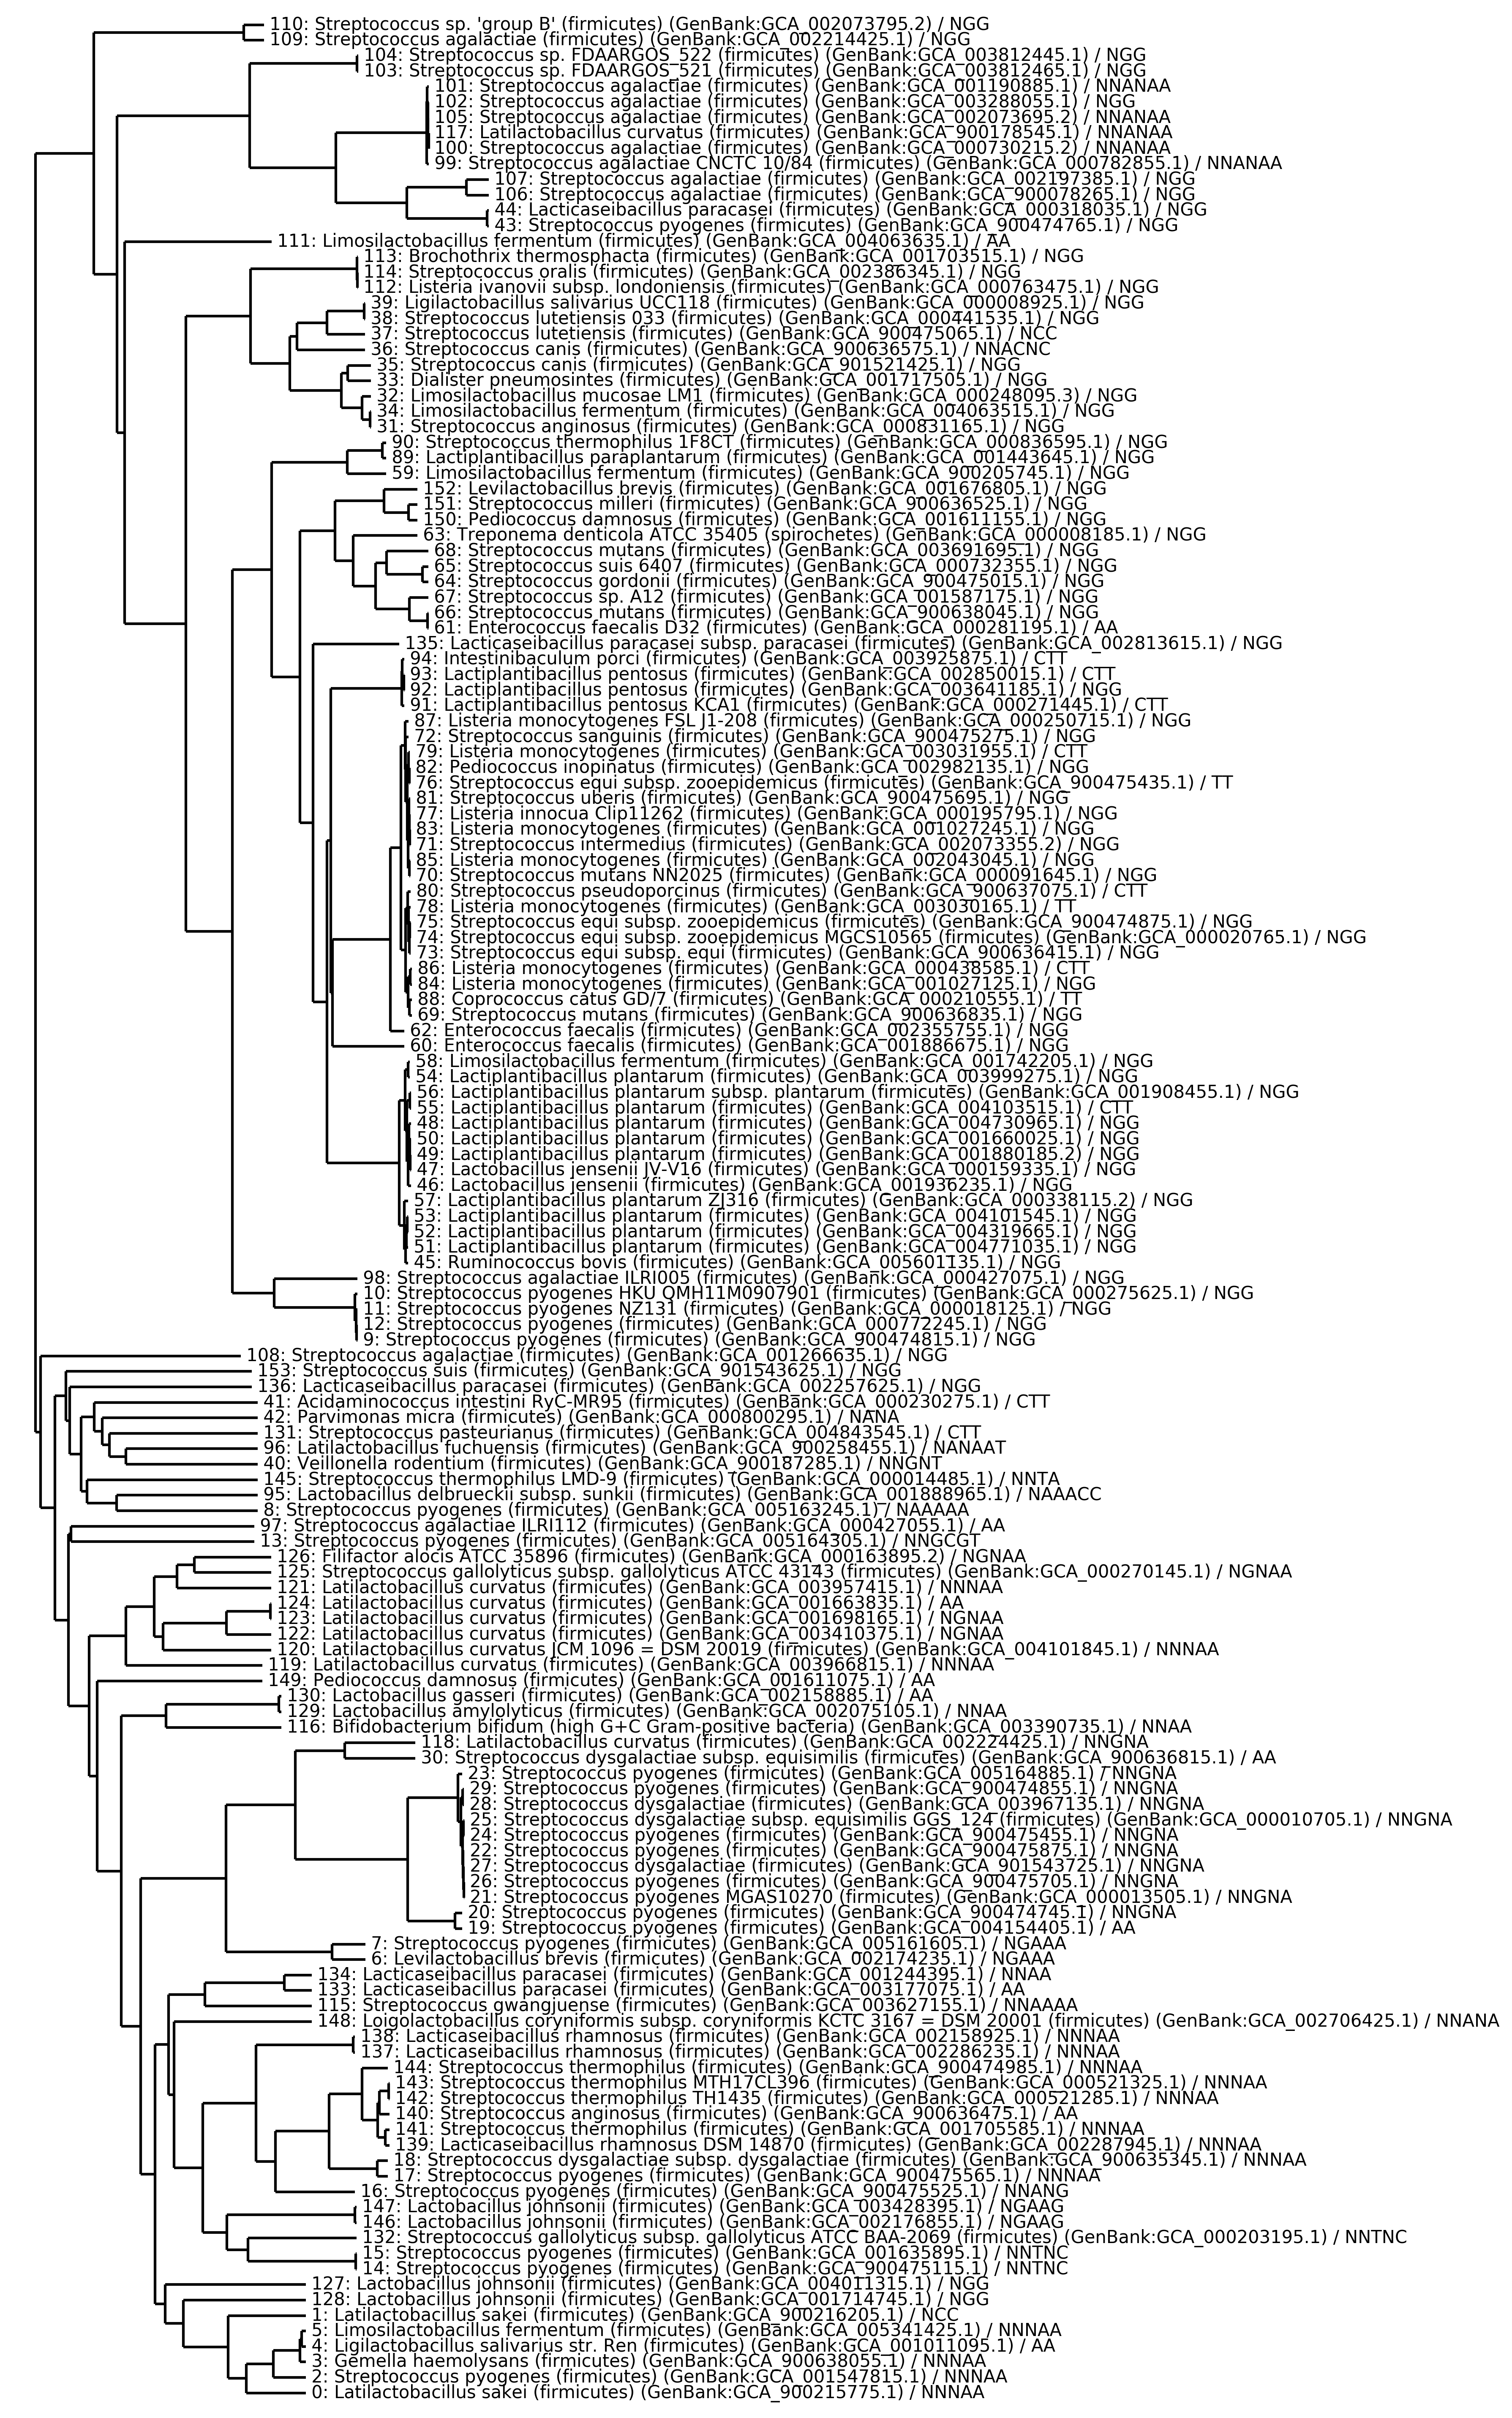

In [119]:
plt.rcParams["figure.figsize"] = (6,25)

Phylo.draw(UGMATree,axis=["off"], label_func=lambda x: x.name, do_show=False)
fig = plt.gcf()
fig.savefig("img.svg", format="svg", dpi=1200)